In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
import logging
import matplotlib.pyplot as plt

tf.get_logger().setLevel(logging.ERROR)
from notebooks.load_dataset.load_dataset import (
    classes,
    x_train,
    y_train,
    x_test,
    y_test,
)

In [10]:
class_names = {
    0: classes[0],
    1: classes[1],
    2: classes[2],
    3: classes[3],
    4: classes[4],
    5: classes[5],
    6: classes[6],
    7: classes[7],
    8: classes[8],
    9: classes[9],
}

In [11]:
def preprocess_image_input(input_images):
    input_images = input_images.astype("float32")
    output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
    return output_ims


def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.resnet.ResNet50(
        input_shape=(224, 224, 3), include_top=False, weights="imagenet"
    )(inputs)
    return feature_extractor


def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x


def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7, 7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output


def define_compile_model():
    inputs = tf.keras.layers.Input(shape=(32, 32, 3))

    classification_output = final_model(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=classification_output)

    model.compile(
        optimizer="SGD", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

    return model

In [12]:
train_X = preprocess_image_input(x_train)
valid_X = preprocess_image_input(x_test)

In [ ]:
model = define_compile_model()

model.summary()

In [ ]:
history = model.fit(
    train_X,
    y_train,
    epochs=5,
    validation_split=0.2,
    batch_size=64,
)

In [ ]:
model.save("resnet_best.keras")

In [ ]:
loss, accuracy = model.evaluate(valid_X, y_test, batch_size=64)

In [13]:
model = tf.keras.models.load_model("models/resnet_best.h5")

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2  (None, 224, 224, 3)       0         
 D)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              209817

e:\Goit\projects\Data_Science_core\final_data_project\ds_project
1/1 [==============================] - 4s 4s/step
 Labels:      [5 1 7 2 4 0 5 6 8 7 6 3 1 3 6]
 Predictions: [5 1 7 0 7 0 3 6 8 7 6 7 1 3 3]


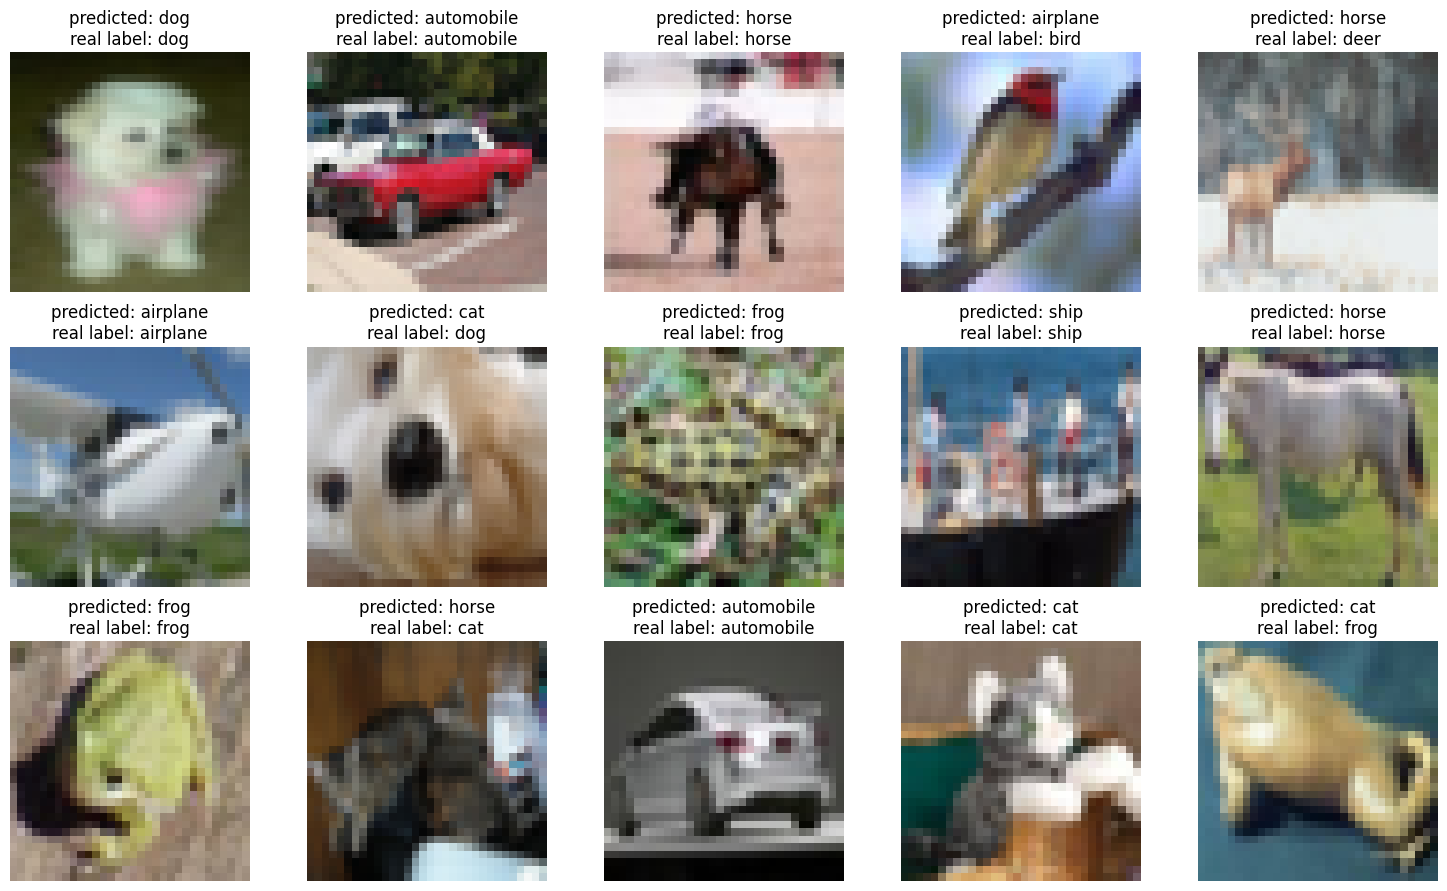

In [5]:
from results.functions import visualize_predictions, history_plot

visualize_predictions(model)

In [6]:
history_plot(history)

NameError: name 'history' is not defined

In [14]:
from results.functions import calculate_percent_right

calculate_percent_right(valid_X, y_test, model)

<class 'numpy.ndarray'>
 20/313 [>.............................] - ETA: 23:42

KeyboardInterrupt: 